In [47]:
import os
import cv2
import numpy
import pandas
import pickle
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [48]:
### Constants
TRAIN_PATH = "./dataset/train_data" # path to the dataset
TEST_PATH = "./dataset/test_data" # path to the dataset
VAL_PATH = "./dataset/val_data" # path to the dataset
LABEL_PATH = './media/labels.csv' # path to the labels csv file
RESULT_PATH = "./dataloader_model_trained" # path to the labels csv file
BATCH_SIZE_VAL = 50 # size of batches during training
STEPS_X_EPOCH = 2000 # number of steps per epoch
N_EPOCHS = 30 # number of epochs for training
IMG_DIM = (32,32,3) # dimensions of the images (height, width, channels)

In [49]:
### Functions
def sorted_imagefolder(root, transform):
	# Ensure the folder names are sorted numerically
	folder_names = sorted(os.listdir(root), key=lambda x: int(x))

	# Create a mapping of folder names to numeric labels
	class_to_idx = {folder: idx for idx, folder in enumerate(folder_names)}

	# Create an ImageFolder instance
	dataset = datasets.ImageFolder(root=root, transform=transform)

	# Override the class_to_idx to match the sorted order
	dataset.class_to_idx = class_to_idx

	# Update the dataset to ensure it uses our sorted classes
	dataset.classes = folder_names  # Update classes attribute
	dataset.samples = [(os.path.join(root, folder, f), class_to_idx[folder]) 
					for folder in folder_names 
					for f in os.listdir(os.path.join(root, folder))]

	return dataset

def grayscale(img):
	import torchvision.transforms as transforms
	from torchvision.transforms import functional
	"""function to convert the image to grayscale"""
	if img is None or not isinstance(img, numpy.ndarray) or len(img.shape) == 2:  # Assuming 'grayscale' starts here
		return img  # return it as is
	else:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
		return img

def equalize(img):
	"""Function to equalize the histogram for contrast adjustment."""
	if img is None:
		return img  # Return None as is

	# Check if img is a tensor and convert to NumPy array
	if isinstance(img, torch.Tensor):
		img = img.detach().cpu().numpy()  # Convert to NumPy array

	if not isinstance(img, numpy.ndarray):
		print("Received non-array image: ", type(img))
		return img

	img = img.astype(numpy.uint8)  # Ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img)  # Apply histogram equalization

	return img

def t_sign_model(n_classes):
	"""funtion to define the CNN model"""
	n_kernels = 60 # number of kernels
	kernel_size_5x5 = (5, 5) # size of the kernels (5x5)
	kernel_size_3x3 = (3, 3) # size of the second kernel (3x3)
	pool_size = (2, 2) # size of the pooling window (2x2): reduces img size by half to prevent overfitting
	n_nodes = 500 # number of nodes in the fully connected layer

	# initialize the model
	model = Sequential()

	# First convolutional block (add more conv layers = less features but more accurate)
	model.add((Conv2D(n_kernels, kernel_size_5x5, input_shape=(IMG_DIM[0], IMG_DIM[1], 1), activation='relu')))
	model.add((Conv2D(n_kernels, kernel_size_5x5, activation='relu'))) # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size)) # max pooling layer

	# Second convolutional block
	model.add((Conv2D(n_kernels // 2, kernel_size_3x3, activation='relu'))) # 3rd conv layer with smaller kernel size
	model.add((Conv2D(n_kernels // 2, kernel_size_3x3, activation='relu'))) # 4th conv layer
	model.add(MaxPooling2D(pool_size=pool_size)) # max pooling layer
	model.add(Dropout(0.5)) # dropout layer to prevent overfitting

	# Fully connected layers
	model.add(Flatten()) # flatten the output for the fully connected layer
	model.add(Dense(n_nodes, activation='relu')) # fully connected layer with ReLU activation
	model.add(Dropout(0.5)) # dropout layer for regularization
	model.add(Dense(n_classes, activation='softmax')) # output layer with softmax for multi-class classification

	# compile the model with Adam optimizer and categorical cross-entropy loss
	model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [50]:
### Classes
class CustomTransform:
	"""Custom transformation class to apply grayscale, histogram equalization, and normalization."""
	def __init__(self):
		pass

	def __call__(self, img):
		# Apply the custom transformations
		img = grayscale(img) # convert to grayscale
		img = equalize(img) # equalize histogram
		img = img / 255 # normalize pixel values to the range [0, 1] instead of [0, 255]
		return img

class TSignModel:
	def __init__(self, n_classes, img_dim, n_kernels=60, n_nodes=500, kernel_size_5x5=(5, 5), 
				 kernel_size_3x3=(3, 3), pool_size=(2, 2), dropout_rate=0.5, learning_rate=0.001):
		"""
		Initializes the TSignModel class with the specified parameters.
		
		Parameters:
		- n_classes (int): Number of output classes.
		- img_dim (tuple): Dimensions of the input images (height, width, channels).
		- n_kernels (int): Number of kernels for convolutional layers.
		- n_nodes (int): Number of nodes in the fully connected layer.
		- kernel_size_5x5 (tuple): Size of the first convolutional kernel.
		- kernel_size_3x3 (tuple): Size of the second convolutional kernel.
		- pool_size (tuple): Size of the pooling window.
		- dropout_rate (float): Rate of dropout for regularization.
		- learning_rate (float): Learning rate for the optimizer.
		"""
		self.n_classes = n_classes
		self.img_dim = img_dim
		self.n_kernels = n_kernels
		self.n_nodes = n_nodes
		self.kernel_size_5x5 = kernel_size_5x5
		self.kernel_size_3x3 = kernel_size_3x3
		self.pool_size = pool_size
		self.dropout_rate = dropout_rate
		self.learning_rate = learning_rate
		self.model = self._build_model()

	def _build_model(self):
		"""Defines the CNN model."""
		model = Sequential()

		# First convolutional block
		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, input_shape=(self.img_dim[0], self.img_dim[1], 1), activation='relu'))
		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer

		# Second convolutional block
		model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 3rd conv layer
		model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 4th conv layer
		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer
		model.add(Dropout(self.dropout_rate))  # dropout layer

		# Fully connected layers
		model.add(Flatten())  # flatten the output for the fully connected layer
		model.add(Dense(self.n_nodes, activation='relu'))  # fully connected layer
		model.add(Dropout(self.dropout_rate))  # dropout layer
		model.add(Dense(self.n_classes, activation='softmax'))  # output layer

		# Compile the model
		model.compile(optimizer=Adam(learning_rate=self.learning_rate), 
					loss='categorical_crossentropy', 
					metrics=['accuracy'])
		return model

	def get_model(self):
		"""Returns the constructed model."""
		return self.model

In [51]:
transform = CustomTransform()

# Split dataset into train, val, and test sets
train_dataset = sorted_imagefolder(TRAIN_PATH, transform)
test_dataset = sorted_imagefolder(TEST_PATH, transform)
val_dataset = sorted_imagefolder(VAL_PATH, transform)

# total number of classes
n_classes = len(train_dataset.classes)
print("Total Classes Detected:", n_classes)

Total Classes Detected: 38


In [52]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)

# print the shapes of the datasets
print("Data Shapes")
print("Train", len(train_loader.dataset)) # print training data shape
print("Validation", len(val_loader.dataset)) # print validation data shape
print("Test", len(test_loader.dataset)) # print test data shape

Data Shapes
Train 38550
Validation 380
Test 380


data shape  (38, 2) <class 'pandas.core.frame.DataFrame'>
[159, 1949, 1838, 1860, 779, 622, 692, 1643, 1590, 324, 559, 855, 1932, 621, 837, 479, 1320, 512, 1592, 765, 330, 1302, 360, 1200, 870, 644, 1023, 618, 293, 1770, 453, 652, 1723, 1590, 1239, 1177, 1260, 1080]


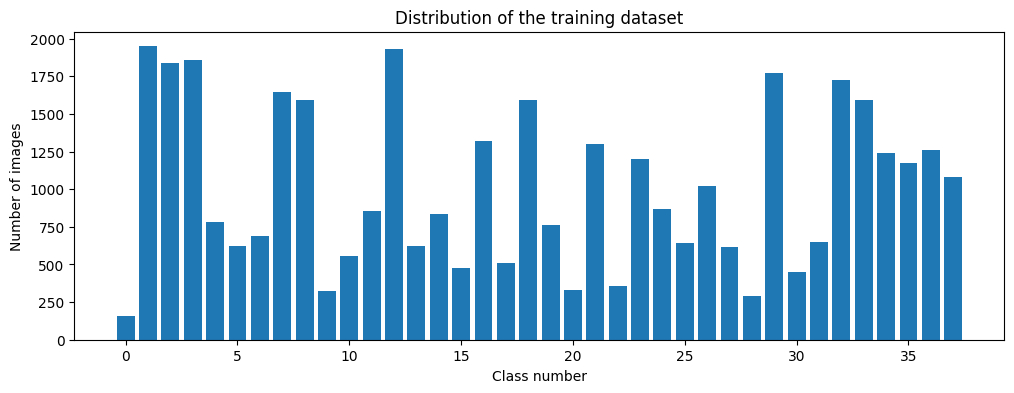

In [53]:
# read the label data from csv file
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class
sample_x_class = [] # list for the number of samples per class

# Calculate sample_x_class from your images and class_labels
for i in range(n_classes):
	count = sum(1 for img, label in train_dataset.imgs if label == i)
	sample_x_class.append(count)

# plot the distribution of training dataset
print(sample_x_class)
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [54]:
X_train = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in train_dataset.imgs])
X_val = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in val_dataset.imgs])
X_test = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in test_dataset.imgs])

y_train = numpy.array([label for img, label in train_dataset.imgs])
y_val = numpy.array([label for img, label in val_dataset.imgs])
y_test = numpy.array([label for img, label in test_dataset.imgs])

# reshape the data to add a depth of 1 (grayscale images have only one channel)
X_train = X_train.reshape(X_train.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_val = X_val.reshape(X_val.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_test = X_test.reshape(X_test.shape[0], IMG_DIM[0], IMG_DIM[1], 1)

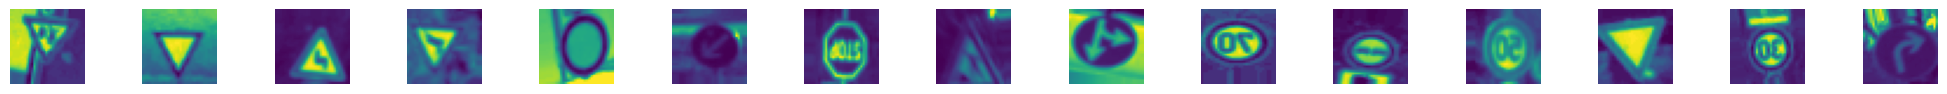

In [55]:
# create an image data generator for augmenting the training data
img_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally by 10%
							height_shift_range=0.1, # randomly shift images vertically by 10%
							zoom_range=0.2, # randomly zoom in or out
							shear_range=0.1, # randomly shear the images
							rotation_range=10, # randomly rotate images by up to 10 degrees
							horizontal_flip=True,
							vertical_flip=True,
							brightness_range=(0.5, 1.5))
img_gen.fit(X_train) # fit the generator on the training data
batches = img_gen.flow(X_train, y_train, batch_size=20) # generate augmented images
X_batch, y_batch = next(batches) # get the next batch

# display some augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
	axs[i].imshow(X_batch[i].reshape(IMG_DIM[0], IMG_DIM[1])) # reshape to 32x32 and display
	axs[i].axis('off') # hide axis (for cleaner display)
plt.show()

# convert labels to one-hot encoded format
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

In [56]:
# build and train the model
model = TSignModel(n_classes=n_classes, img_dim=IMG_DIM)
print(model.get_model().summary())

history = model.get_model().fit(
	img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE_VAL), # train the model using data augmentation
	steps_per_epoch=STEPS_X_EPOCH, # number of steps per epoch
	epochs=N_EPOCHS, # number of epochs
	validation_data=(X_val, y_val), # validation data
	shuffle=True # shuffle data during training
)

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,038 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,518 (1.43 MB)

 Trainable params: 375,518 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30


/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 771/2000 ━━━━━━━━━━━━━━━━━━━━ 1:48 88ms/step - accuracy: 0.0462 - loss: 4.0241

/opt/homebrew/Cellar/python@3.12/3.12.7/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - accuracy: 0.0475 - loss: 3.7567 - val_accuracy: 0.0263 - val_loss: 3.8014
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.0475 - loss: 3.5159 - val_accuracy: 0.0263 - val_loss: 3.8022
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 76s 38ms/step - accuracy: 0.0477 - loss: 3.5012 - val_accuracy: 0.0263 - val_loss: 3.8048
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - accuracy: 0.0496 - loss: 3.4998 - val_accuracy: 0.0263 - val_loss: 3.7898
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.0513 - loss: 3.4989 - val_accuracy: 0.0263 - val_loss: 3.7968
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.0494 - loss: 3.4999 - val_accuracy: 0.0263 - val_loss: 3.7934
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 114s 57ms/step - accuracy: 0.0495 - loss: 3.4981 - val_accuracy: 0.0263 - val_loss: 3.7810
Epoch 8/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.0497 - loss: 3.4

2024-10-27 23:24:53.602937: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.0500 - loss: 3.4974 - val_accuracy: 0.0263 - val_loss: 3.8073
Epoch 29/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.0492 - loss: 3.4959 - val_accuracy: 0.0263 - val_loss: 3.7862
Epoch 30/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.0493 - loss: 3.4987 - val_accuracy: 0.0263 - val_loss: 3.8043


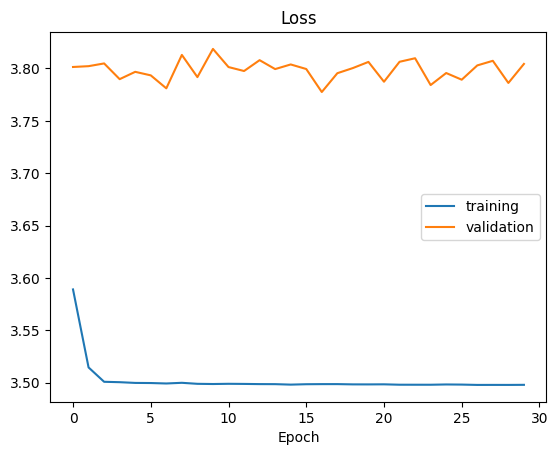

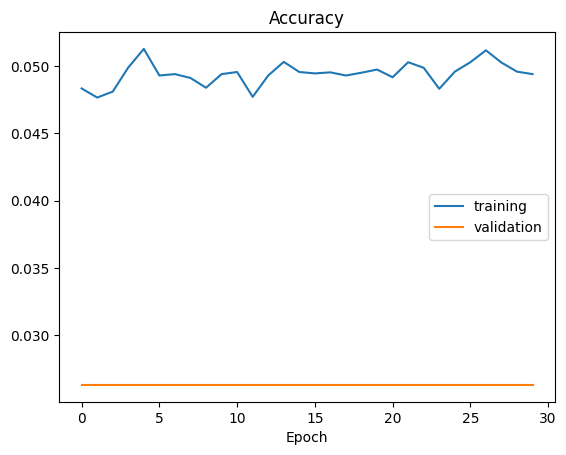

Last Validation Loss: 3.8043360710144043
Last Validation Accuracy: 0.02631578966975212
Test Score: 3.8043360710144043
Test Accuracy: 0.02631578966975212


In [57]:
# plot the training and validation loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# plot the training and validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Get the last values of validation loss
last_val_loss = history.history['val_loss'][-1]
print(f'Last Validation Loss: {last_val_loss}')

# Get the last values of validation accuracy
last_val_accuracy = history.history['val_accuracy'][-1]
print(f'Last Validation Accuracy: {last_val_accuracy}')


# evaluate the model on the test set
score = model.get_model().evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0]) # print test loss
print('Test Accuracy:', score[1]) # print test accuracy

# save the trained model
pickle_out = open(RESULT_PATH + N_EPOCHS + ".p", "wb")
pickle.dump(model, pickle_out) # serialize and save the model
pickle_out.close()